# Aplicacion de Machine Learning para la Prediccion de Desempleo Regional en Panama
## Un Enfoque de Politica Publica Basado en Datos y Analisis Geoespacial
### Trabajo Fin de Master - Data Science

**Autor:** Henry De Gracia 
**Institucion:** Universidad Complutense de Madrid (UCM) 
**Master:** Big Data y Data Science 
**Tutores:** Carlos Ortega y Santiago Mota 
**Fecha:** Febrero 2026

## Indice de Contenidos

1. [Introduccion y Motivacion](#1-introduccion-y-motivacion)
2. [Marco Teorico](#2-marco-teorico)
3. [Fuentes de Datos y Preprocesamiento](#3-fuentes-de-datos-y-preprocesamiento)
4. [Analisis Exploratorio](#4-analisis-exploratorio)
5. [Feature Engineering](#5-feature-engineering)
6. [Modelado y Evaluacion](#6-modelado-y-evaluacion)
7. [Analisis Geoespacial](#7-analisis-geoespacial)
8. [Productivizacion: Dashboard y Predictor](#8-productivizacion)
9. [Resultados y Discusion](#9-resultados-y-discusion)
10. [Recomendaciones de Politica Publica](#10-recomendaciones-de-politica-publica)
11. [Conclusiones y Trabajo Futuro](#11-conclusiones-y-trabajo-futuro)
12. [Bibliografia](#12-bibliografia)

In [1]:
# Configuracion inicial - carga de datos y librerias
import pandas as pd
import numpy as np
import json
import sys
from pathlib import Path
from IPython.display import display, HTML, Image, Markdown
import warnings
warnings.filterwarnings('ignore')

ROOT = Path('..').resolve()
sys.path.insert(0, str(ROOT))

from src.config import REPORTS_DIR, FIGURES_DIR, PROCESSED_DATA_DIR, MODELS_DIR
from src.config import COLOR_MAP, RIESGO_BAJO, RIESGO_CRITICO

# Cargar datos del modelo
with open(REPORTS_DIR / 'resumen_modelo.json', 'r', encoding='utf-8') as f:
    resumen = json.load(f)

df_pred = pd.read_csv(REPORTS_DIR / 'predicciones_modelo.csv')
df_cv = pd.read_csv(REPORTS_DIR / 'cv_resultados.csv')
df_feat = pd.read_csv(REPORTS_DIR / 'feature_importance.csv', index_col=0)
df_desempleo = pd.read_csv(PROCESSED_DATA_DIR / 'desempleo_por_provincia.csv')
df_features = pd.read_csv(PROCESSED_DATA_DIR / 'features_desempleo.csv')

# Importar funciones de visualizacion
from src.visualization.graficos_interactivos import (
    fig_evolucion_temporal, fig_heatmap_provincia_periodo,
    fig_real_vs_prediccion_barras, fig_scatter_prediccion_vs_real,
    fig_feature_importance, fig_comparacion_modelos,
    fig_distribucion_residuos, fig_boxplot_desempleo,
    fig_cv_metricas_por_periodo
)

print(f'Datos cargados: {len(df_pred):,} predicciones, '
      f'{resumen["n_provincias"]} provincias, {resumen["n_periodos"]} periodos')

Datos cargados: 1,605 predicciones, 13 provincias, 17 periodos


---
## 1. Introduccion y Motivacion

Panama es una economia en transicion que, a pesar de su crecimiento sostenido del PIB en la ultima decada, presenta desigualdades estructurales significativas en su mercado laboral. Mientras provincias como Panama y Colon concentran la actividad economica del canal y el sector servicios, las comarcas indigenas (Ngabe-Bugle, Guna Yala, Embera-Wounaan) enfrentan tasas de desempleo que pueden triplicar el promedio nacional.

La pandemia de COVID-19 agravo estas brechas: en 2020 el desempleo nacional se disparo al 18.5%, pero la recuperacion fue desigual entre regiones. Comprender y predecir estas dinamicas a nivel provincial es fundamental para:

- **Politicas publicas focalizadas:** identificar provincias con riesgo critico de desempleo para dirigir programas de empleo y capacitacion.
- **Planificacion presupuestaria:** anticipar la demanda de servicios sociales por region.
- **Evaluacion de impacto:** medir como variables estructurales (educacion, informalidad, tamano de empresa) determinan el desempleo regional.

### Objetivo del proyecto

Construir un **modelo predictivo de la tasa de desempleo a nivel provincial** en Panama, utilizando datos oficiales del Instituto Nacional de Estadistica y Censo (INEC) y el Banco Mundial, cubriendo el periodo 2011-2024. El modelo debe:

1. Predecir la tasa de desempleo por provincia con precision razonable.
2. Clasificar el nivel de riesgo laboral (bajo, moderado, critico) por region.
3. Identificar las variables mas determinantes del desempleo regional.
4. Estar productivizado en un dashboard interactivo que permita hacer predicciones con nuevos valores.

### Alcance

El analisis cubre **13 provincias y comarcas** de Panama a lo largo de **17 periodos** (2011 a 2024), con desagregacion por **area** (total, urbana, rural) y **sexo** (total, hombres, mujeres), generando un dataset de **1,605 observaciones**. Se evaluan 5 algoritmos de machine learning con validacion cruzada temporal Leave-One-Period-Out (LOPO).

---
## 2. Marco Teorico

El desempleo, definido por la Organizacion Internacional del Trabajo (OIT) como la proporcion de la Poblacion Economicamente Activa (PEA) que busca empleo activamente sin encontrarlo, es un indicador clave del bienestar economico de una region. A nivel subnacional, las disparidades en las tasas de desempleo responden a factores estructurales como la composicion sectorial de la economia, el nivel educativo de la poblacion, la informalidad laboral y el tamano del tejido empresarial (Blanchard & Katz, 1992).

En economias en desarrollo como Panama, el desempleo oficial tiende a subestimar la problematica real del mercado laboral, ya que el **subempleo** (personas que trabajan menos horas de las deseadas) y la **informalidad** (empleo sin proteccion social ni contrato) absorben parte de la fuerza laboral que en economias formalizadas apareceria como desempleada (OIT, 2023). Por ello, un modelo predictivo robusto debe incorporar estas variables como predictores complementarios.

---
## 3. Fuentes de Datos y Preprocesamiento

### 3.1 Fuentes de datos

El proyecto integra tres fuentes oficiales de datos:

| Fuente | Tipo | Variables | Cobertura |
|--------|------|-----------|----------|
| **INEC Panama** | 560 archivos Excel (Encuesta de Mercado Laboral), 59 cuadros procesados | Tasas de desempleo, participacion, PEA, educacion, sector economico, salarios, informalidad, subempleo | 2011-2024, provincial |
| **Banco Mundial** | API automatica (13 indicadores, 8 usados en el modelo) | PIB per capita, crecimiento PIB, inflacion, desempleo juvenil, Gini, poblacion | 2018-2024, nacional |
| **HDX** | Shapefiles (nivel administrativo 1) | Geometrias de 13 provincias y comarcas | 2024 |

**Datos del INEC**: Se descargaron automaticamente 560 archivos Excel mediante scripts que acceden a los cuadros publicados en la web del INEC (https://www.inec.gob.pa/publicaciones/Default2.aspx?ID_CATEGORIA=5&ID_SUBCATEGORIA=38) para cada encuesta semestral. De estos, se procesaron 59 cuadros clave (Cuadros 2, 1A, 4, 6, 13, 16, 19, 22, 25 y 39) que contienen las variables relevantes para el modelo. El periodo 2020 corresponde a una encuesta telefonica reducida debido a la pandemia y fue excluido del procesamiento.

**Datos del Banco Mundial**: Se obtuvieron via la API publica (https://api.worldbank.org/v2), descargando 13 indicadores macroeconomicos para Panama, de los cuales 8 se integran al modelo (PIB, inflacion, Gini, gasto en educacion, desempleo juvenil, exportaciones, PIB per capita y poblacion). Estas variables nacionales se asignaron uniformemente a todas las provincias en cada ano, funcionando como contexto macroeconomico.

**Shapefiles**: Se descargaron de Humanitarian Data Exchange (https://data.humdata.org/dataset/cod-ab-pan), utilizando unicamente el nivel administrativo 1 (provincias) para los mapas coropleticos.

### 3.2 Preprocesamiento

El procesamiento de datos se realizo en el script `src/data/procesar_datos_inec.py` y consto de:

1. **Lectura y parseo** de los 59 cuadros Excel seleccionados del INEC, extrayendo las tablas relevantes (tasas por provincia, educacion, sector economico, salarios).
2. **Estandarizacion de nombres** de provincias entre fuentes (ej. "Ngabe Bugle" -> "Ngabe-Bugle").
3. **Consolidacion** en un unico DataFrame con estructura provincia x periodo x area x sexo.
4. **Integracion** con indicadores del Banco Mundial (merge por anio).
5. **Imputacion** de valores faltantes con la mediana por provincia.

El resultado es un dataset de **1,605 registros** con las siguientes dimensiones:

In [2]:
# Resumen del dataset procesado
resumen_datos = pd.DataFrame({
    'Dimension': ['Registros totales', 'Provincias/Comarcas', 'Periodos temporales',
                  'Cobertura temporal', 'Areas (total/urbana/rural)',
                  'Sexos (total/hombres/mujeres)', 'Variables originales'],
    'Valor': [f"{len(df_desempleo):,}", df_desempleo['provincia'].nunique(),
              df_desempleo['periodo'].nunique(),
              f"{df_desempleo['periodo'].min()} a {df_desempleo['periodo'].max()}",
              df_desempleo['area'].nunique() if 'area' in df_desempleo.columns else 'N/A',
              df_desempleo['sexo'].nunique() if 'sexo' in df_desempleo.columns else 'N/A',
              df_desempleo.shape[1]]
})
display(HTML(resumen_datos.to_html(index=False)))

### 3.3 Variables disponibles

Tras la consolidacion, el dataset incluye variables en las siguientes categorias:

- **Mercado laboral:** tasa de desempleo, tasa de participacion, PEA, poblacion ocupada y desocupada, subempleo, informalidad.
- **Educacion:** porcentaje de poblacion sin educacion, con secundaria y con educacion universitaria.
- **Estructura productiva:** porcentaje por sector (primario, secundario, terciario), tamano de empresa, microempresa.
- **Ingresos:** mediana salarial por provincia.
- **Macroeconomia:** PIB per capita, crecimiento PIB, inflacion, desempleo juvenil nacional, indice de Gini.

*Detalle completo de las variables y su construccion en el Anexo (src/data/procesar_datos_inec.py).*

---
## 4. Analisis Exploratorio

El analisis exploratorio completo se encuentra en el Anexo (`notebooks/01_analisis_exploratorio.ipynb`). A continuacion se presentan los hallazgos mas relevantes para entender el contexto del modelo.

### 4.1 Evolucion temporal del desempleo

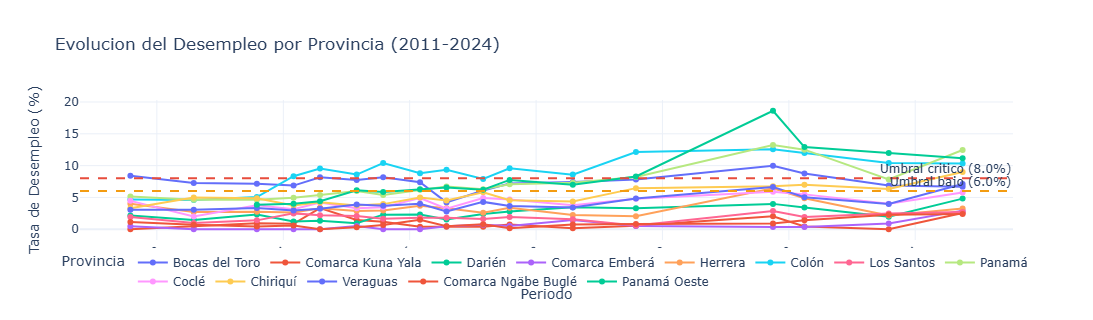

In [3]:
fig = fig_evolucion_temporal(df_pred)
fig.update_layout(height=320, title='Evolucion del Desempleo por Provincia (2011-2024)')
fig.show()

**Observaciones clave:**

- **Heterogeneidad provincial**: existe una brecha significativa entre provincias. Colon y las comarcas indigenas presentan tasas consistentemente superiores al 10%, mientras que Los Santos y Herrera se mantienen por debajo del 5%.
- **Impacto COVID-19 (2020-2021)**: se observa un pico generalizado en 2020 (encuesta telefonica), seguido de una recuperacion gradual pero desigual. Las provincias con mayor informalidad laboral sufrieron caidas mas pronunciadas.
- **Tendencia reciente**: entre 2023 y 2024 se observa una estabilizacion, con la mayoria de provincias retornando a niveles pre-pandemia.

### 4.2 Distribucion del desempleo por provincia

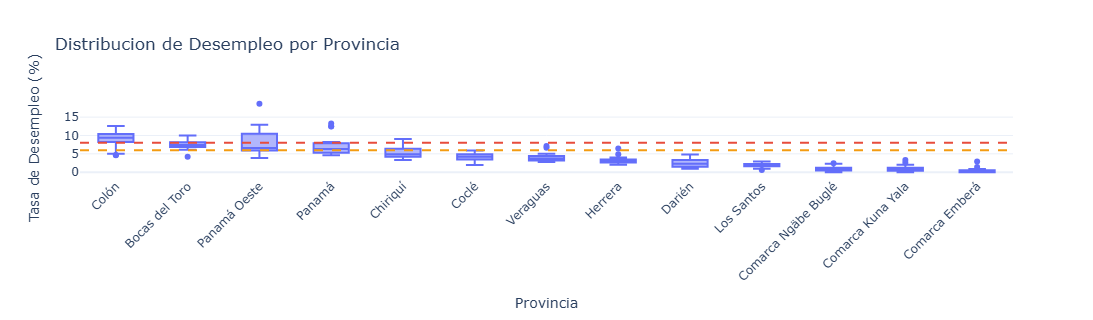

In [4]:
fig = fig_boxplot_desempleo(df_pred)
fig.update_layout(height=320)
fig.show()

El boxplot confirma la heterogeneidad: las provincias con mayor variabilidad (cajas amplias) son aquellas donde el desempleo es mas sensible a los ciclos economicos. Las comarcas indigenas presentan medianas elevadas pero tambien alta dispersion, lo que sugiere datos limitados o volatilidad estructural.

### 4.3 Mapa de calor: provincia x periodo

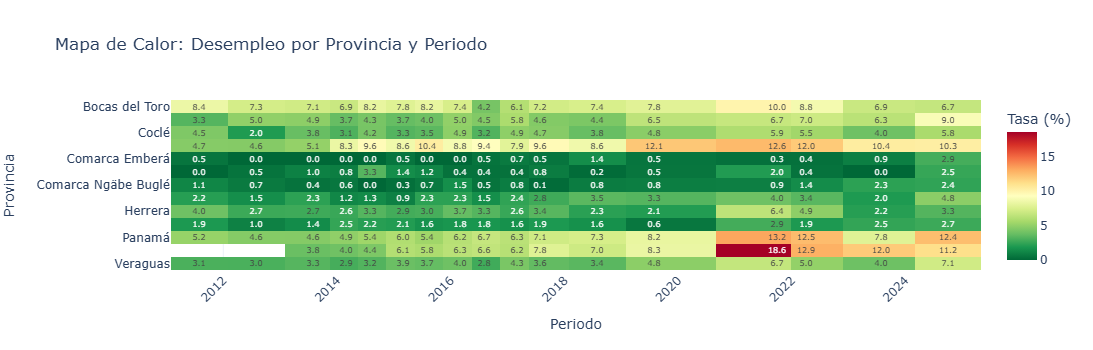

In [5]:
fig = fig_heatmap_provincia_periodo(df_pred)
fig.update_layout(height=350)
fig.show()

El mapa de calor revela patrones claros:
- **Cluster de riesgo critico** (rojo intenso) en Colon y comarcas entre 2019-2021.
- **Cluster de riesgo bajo** (verde) en las provincias centrales (Herrera, Los Santos) de forma persistente.
- La franja de 2020-2021 muestra el impacto generalizado del COVID-19 en todas las regiones.

### 4.4 Estadisticas descriptivas por provincia

Para cuantificar las diferencias regionales, se calcula la tasa de desempleo promedio, minima y maxima por provincia (area=total, sexo=total) a lo largo de los 17 periodos:

In [6]:
# Ranking de provincias por desempleo promedio
df_total = df_desempleo[(df_desempleo['area']=='total') & (df_desempleo['sexo']=='total')].copy()

ranking = df_total.groupby('provincia')['tasa_desempleo'].agg(['mean', 'std', 'min', 'max']).round(1)
ranking = ranking.sort_values('mean', ascending=False)
ranking.columns = ['Media (%)', 'Desv. Std.', 'Minimo (%)', 'Maximo (%)']
ranking.index.name = 'Provincia'

print('Ranking de Provincias por Tasa de Desempleo Promedio (2011-2024):')
print(f'Rango general: {df_total["tasa_desempleo"].min():.1f}% a {df_total["tasa_desempleo"].max():.1f}%')
print(f'Media nacional: {df_total["tasa_desempleo"].mean():.1f}% | Mediana: {df_total["tasa_desempleo"].median():.1f}%')
display(HTML(ranking.to_html()))

Ranking de Provincias por Tasa de Desempleo Promedio (2011-2024):
Rango general: 0.0% a 18.6%
Media nacional: 4.2% | Mediana: 3.6%


### Hallazgos adicionales del EDA

El analisis exploratorio completo (ver Anexo: `notebooks/01_analisis_exploratorio.ipynb`) revelo ademas:

- **Impacto COVID-19**: el desempleo promedio aumento +2.3 pp tras la pandemia (de 3.7% a 5.9%). Panama Oeste fue la provincia mas afectada (+7.6 pp). La recuperacion fue desigual entre provincias.
- **Brecha de genero**: las mujeres presentan un desempleo promedio de 5.4% vs 3.4% de los hombres (+2.0 pp), persistente en todos los periodos.
- **Brecha urbano-rural**: el desempleo urbano (6.1%) supera al rural (4.2%) en +1.9 pp, porque en areas rurales el desempleo se oculta en informalidad y trabajo de subsistencia.
- **Correlaciones clave**: el sector terciario (+0.77), la mediana salarial (+0.67) y la informalidad (-0.65) son las variables mas correlacionadas con el desempleo. Paradojicamente, las provincias mas "desarrolladas" tienen mayor desempleo registrado.

Estos hallazgos justifican la inclusion de variables como el subempleo, la informalidad y la estructura sectorial como features clave del modelo predictivo.

---
## 5. Feature Engineering

Partiendo de las variables base del dataset consolidado, se crearon 31 features agrupadas en 7 categorias. El objetivo fue capturar dinamicas temporales, interacciones estructurales y contrastes regionales que un modelo lineal simple no detectaria.

| Categoria | # Features | Descripcion | Ejemplo |
|-----------|-----------|-------------|--------|
| **Lag (retardo)** | 3 | Valor del periodo anterior para variables clave | `tasa_desempleo_lag1`: desempleo del periodo previo |
| **Delta (variacion)** | 2 | Cambio respecto al periodo anterior | `tasa_participacion_delta`: cambio en participacion laboral |
| **Contraste** | 3 | Brechas entre subgrupos | `brecha_desempleo_genero`: diferencia entre mujeres y hombres |
| **Ratios** | 3 | Proporciones entre variables | `educacion_alta`: suma de secundaria + universitaria |
| **Temporales** | 2 | Indicadores de contexto temporal | `post_covid`: indicador binario (anio >= 2021) |
| **Interaccion** | 3 | Productos entre features | `lag_x_post_covid`: desempleo previo * indicador COVID |
| **Categoricas** | 15 | Dummies de provincia | `prov_Colon`, `prov_Panama`, etc. (drop_first) |

### Justificacion de las features mas relevantes

- **Features de lag**: la tasa de desempleo del periodo anterior (`tasa_desempleo_lag1`) es el predictor mas potente. El desempleo tiene inercia: si una provincia tenia desempleo alto en el periodo anterior, es muy probable que continue elevado.

- **Interacciones con COVID**: `lag_x_post_covid` captura que el efecto del desempleo previo se amplifica en el periodo post-pandemia, donde la recuperacion no fue uniforme.

- **Subempleo e informalidad**: `pct_subempleo_lag1` resulta ser el feature mas importante del modelo. Las provincias con alto subempleo "visible" (personas que trabajan pocas horas involuntariamente) suelen transicionar a desempleo abierto en periodos de contraccion.

*Implementacion detallada en el Anexo (`src/features/crear_features.py`).*

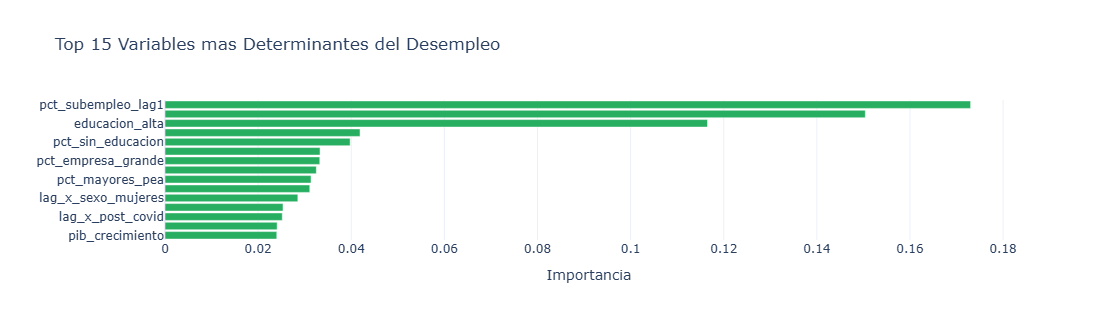

In [7]:
# Top 15 features por importancia en el modelo final
fig = fig_feature_importance(df_feat, top_n=15)
fig.update_layout(height=320, title='Top 15 Variables mas Determinantes del Desempleo')
fig.show()

---
## 6. Modelado y Evaluacion

### 6.1 Estrategia de validacion

Se utilizo **Leave-One-Period-Out (LOPO)** como esquema de validacion cruzada. En cada iteracion se excluye un periodo completo (todas las provincias de ese periodo) como conjunto de test, y se entrena con los periodos restantes. Esta estrategia:

- **Respeta la estructura temporal** de los datos, evitando data leakage al no usar informacion futura para predecir el pasado.
- **Simula un escenario real** de prediccion, donde el modelo se entrena con datos historicos y predice un periodo futuro desconocido.
- Genera **17 evaluaciones independientes** (una por periodo), proporcionando una estimacion robusta del error.

### 6.2 Modelos evaluados

Se compararon **5 algoritmos estudiados durante el master**, desde modelos lineales regularizados (baseline) hasta metodos de ensamble basados en arboles:

| Modelo | Tipo | Justificacion |
|--------|------|---------------|
| **Ridge** | Regresion lineal regularizada (L2) | Baseline robusto, penaliza coeficientes grandes |
| **Lasso** | Regresion lineal regularizada (L1) | Baseline con seleccion automatica de variables |
| **Random Forest** | Ensamble de arboles (bagging) | Captura no linealidades, resistente a overfitting |
| **Gradient Boosting** | Ensamble de arboles (boosting) | Aprendizaje secuencial, alta capacidad predictiva |
| **XGBoost** | Gradient Boosting optimizado | Implementacion eficiente con regularizacion adicional |

La seleccion de estos modelos responde a una progresion natural de complejidad: los modelos lineales proporcionan un baseline interpretable, mientras que los metodos de ensamble permiten evaluar si las relaciones no lineales del mercado laboral justifican la complejidad adicional.

In [9]:
# Tabla comparativa de modelos
df_modelos = pd.DataFrame(resumen['todos_modelos_cv']).T
df_modelos.columns = ['MAE', 'RMSE', 'R-cuadrado']
df_modelos = df_modelos.sort_values('R-cuadrado', ascending=False)
df_modelos.index.name = 'Modelo'

print('Metricas de Validacion Cruzada (LOPO) - Promedio sobre 17 periodos:')
print('=' * 60)
display(HTML(
    df_modelos.style
    .format('{:.4f}')
    .highlight_max(subset=['R-cuadrado'], color='#d4edda')
    .highlight_min(subset=['MAE', 'RMSE'], color='#d4edda')
    .to_html()
))

Metricas de Validacion Cruzada (LOPO) - Promedio sobre 17 periodos:


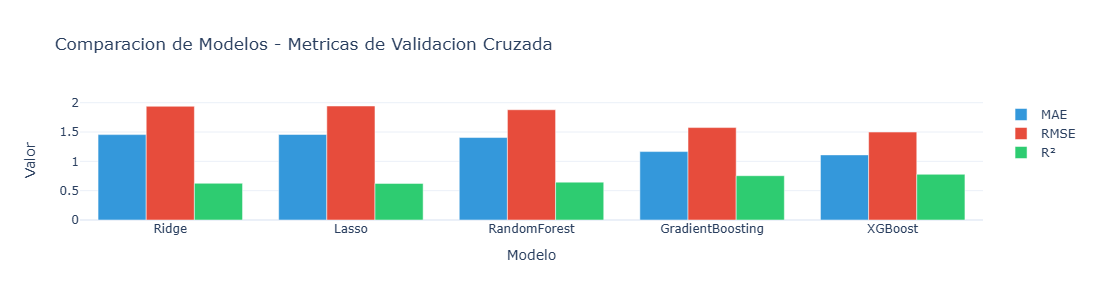

In [10]:
fig = fig_comparacion_modelos(resumen['todos_modelos_cv'])
fig.update_layout(height=300, title='Comparacion de Modelos - Metricas de Validacion Cruzada')
fig.show()

### 6.3 Analisis de resultados

**XGBoost** es el modelo seleccionado con las mejores metricas:

- **R-cuadrado = 0.77**: el modelo explica el 77% de la variabilidad del desempleo regional. Esto es significativo considerando la heterogeneidad entre provincias y la complejidad del fenomeno.
- **MAE = 1.13 puntos porcentuales**: en promedio, la prediccion se desvio 1.13 pp de la tasa real. Para un tomador de decisiones, esto significa que si el modelo predice un desempleo del 8%, el valor real probablemente esta entre 6.9% y 9.1%.
- **RMSE = 1.53 pp**: las desviaciones grandes son penalizadas, y el modelo se mantiene con un error cuadratico razonable.

**Ventaja sobre los modelos lineales**: XGBoost supera a Ridge y Lasso en R-cuadrado por 15 puntos (+0.15), lo que confirma que las relaciones entre las variables del mercado laboral no son puramente lineales. Los arboles de decision capturan interacciones no lineales (ej. el efecto del subempleo se amplifica en periodos post-COVID) que los modelos lineales ignoran.

### 6.4 Clasificacion de riesgo

Ademas de predecir la tasa exacta, el modelo clasifica cada provincia en niveles de riesgo:

| Nivel | Umbral | Interpretacion |
|-------|--------|----------------|
| **Bajo** | < 6% | Mercado laboral saludable |
| **Moderado** | 6% - 10% | Atencion requerida, posible intervencion |
| **Critico** | > 10% | Situacion de emergencia laboral, intervencion prioritaria |

La **precision de clasificacion de riesgo** en validacion cruzada es del **79.4%**, superior al azar (33% con 3 clases). Esto significa que en 4 de cada 5 casos, el modelo asigna correctamente el nivel de riesgo de una provincia.

### 6.5 Estabilidad del modelo por periodo

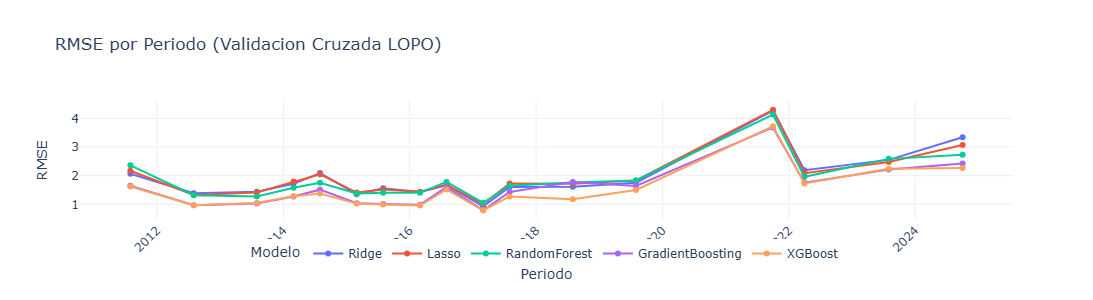

In [11]:
fig = fig_cv_metricas_por_periodo(df_cv, metrica='rmse')
fig.update_layout(height=300, title='RMSE por Periodo (Validacion Cruzada LOPO)')
fig.show()

El grafico muestra la estabilidad del RMSE a lo largo de los periodos. Los picos corresponden a periodos de mayor incertidumbre (2020-2021, impacto COVID), lo cual es esperable y confirma que el modelo es sensible a choques externos no capturados en las variables historicas.

### 6.6 Analisis de residuos

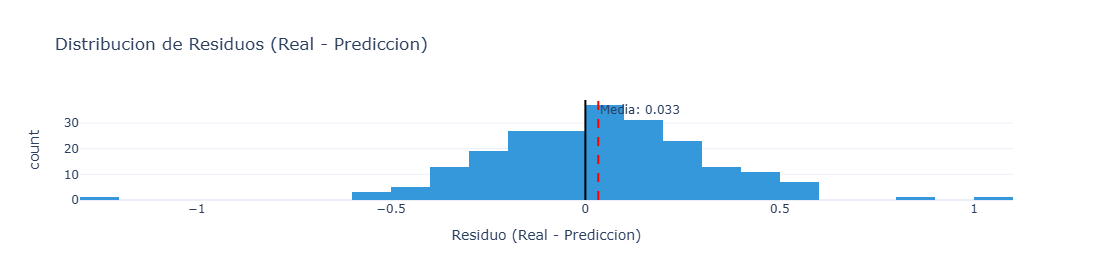

In [12]:
fig = fig_distribucion_residuos(df_pred)
fig.update_layout(height=280, title='Distribucion de Residuos (Real - Prediccion)')
fig.show()

La distribucion de residuos esta centrada en cero y es aproximadamente simetrica, lo que indica que el modelo **no tiene sesgo sistematico**: no sobreestima ni subestima de forma consistente. La cola derecha (residuos positivos, donde el desempleo real supera la prediccion) es ligeramente mas pesada, lo que es preferible desde una perspectiva de politica publica: es mejor que el modelo subestime ligeramente el riesgo a que lo sobreestime.

---
## 7. Analisis Geoespacial

Para complementar el analisis temporal con una perspectiva espacial, se generaron mapas coropleticos que permiten visualizar la distribucion geografica del desempleo y su clasificacion de riesgo.

### 7.1 Mapa de riesgo de desempleo (Octubre 2024)

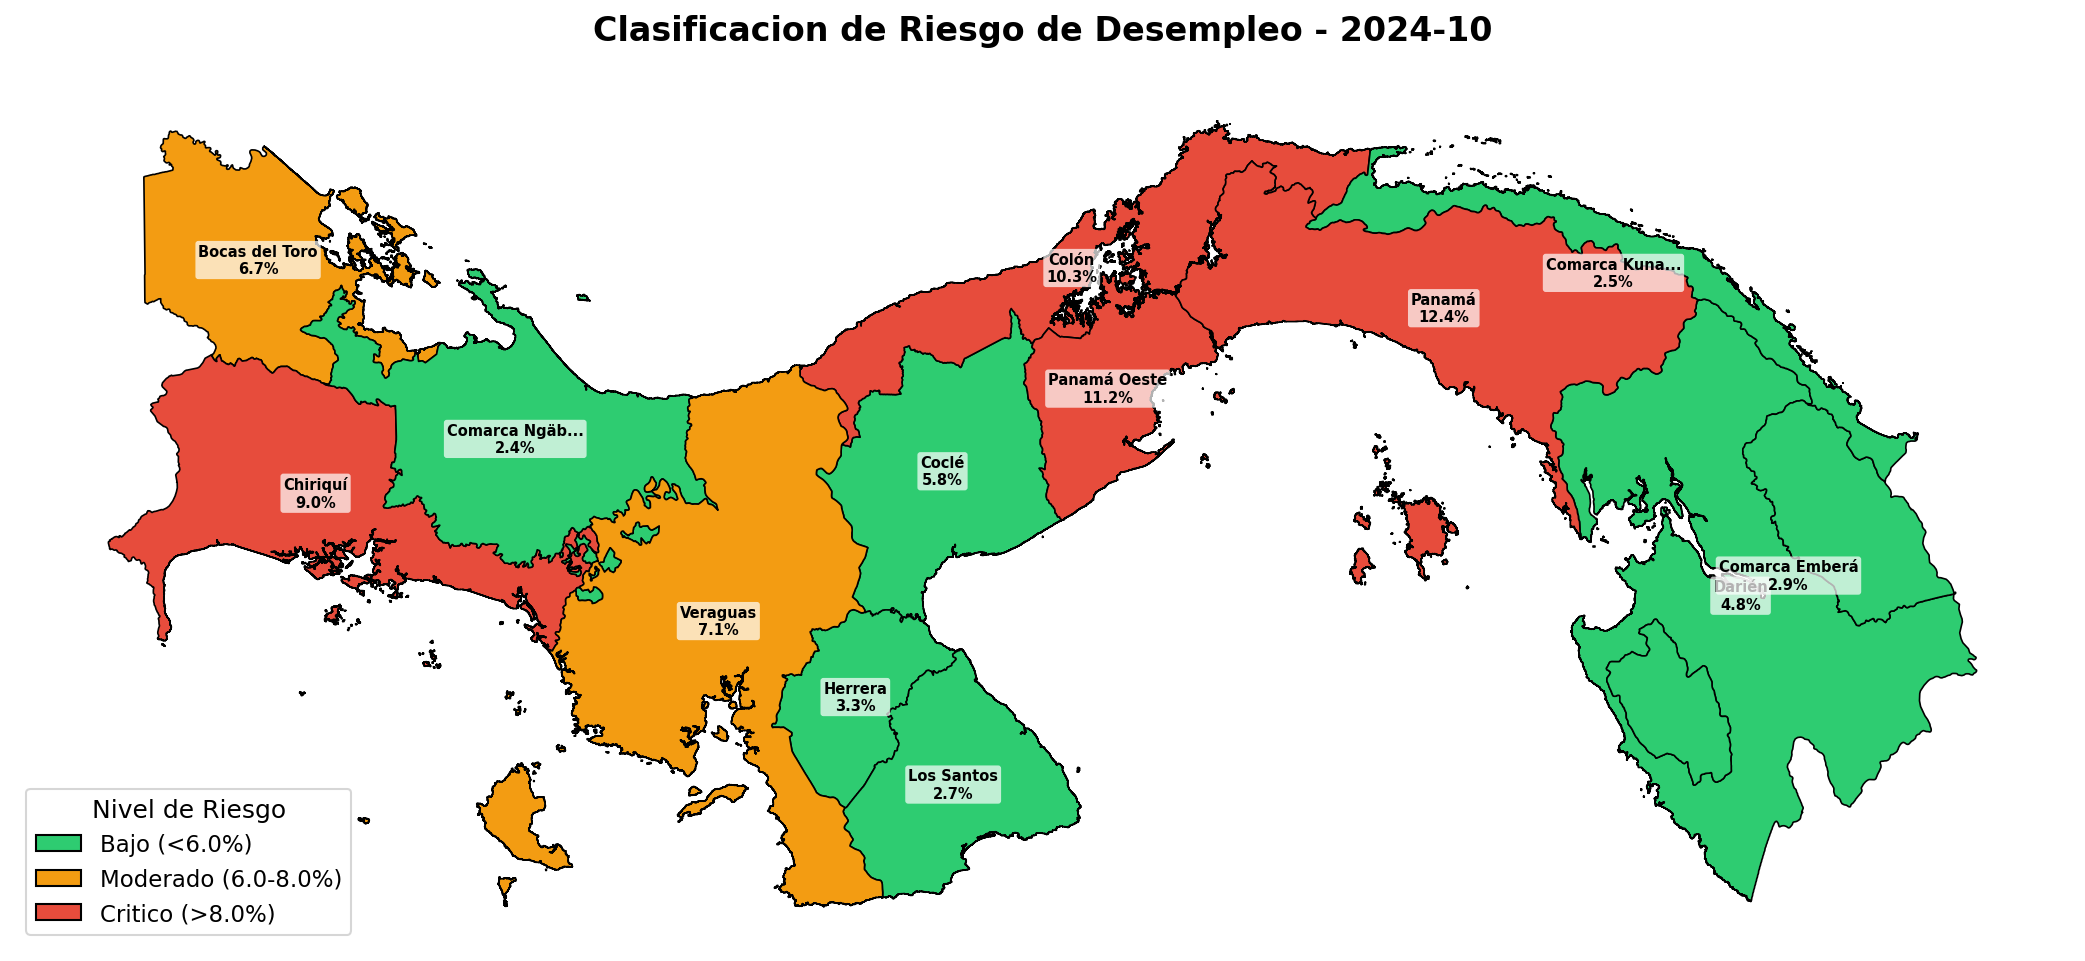

In [13]:
# Mapa de riesgo actual
display(Image(filename=str(FIGURES_DIR / 'mapa_riesgo_2024_10.png'), width=500))

El mapa del ultimo periodo disponible (Octubre 2024) muestra la clasificacion de riesgo por provincia. Las provincias en rojo (riesgo critico) concentran desempleo superior al 10% y requieren atencion prioritaria en politicas de empleo.

### 7.2 Comparacion temporal: 2018 vs 2024

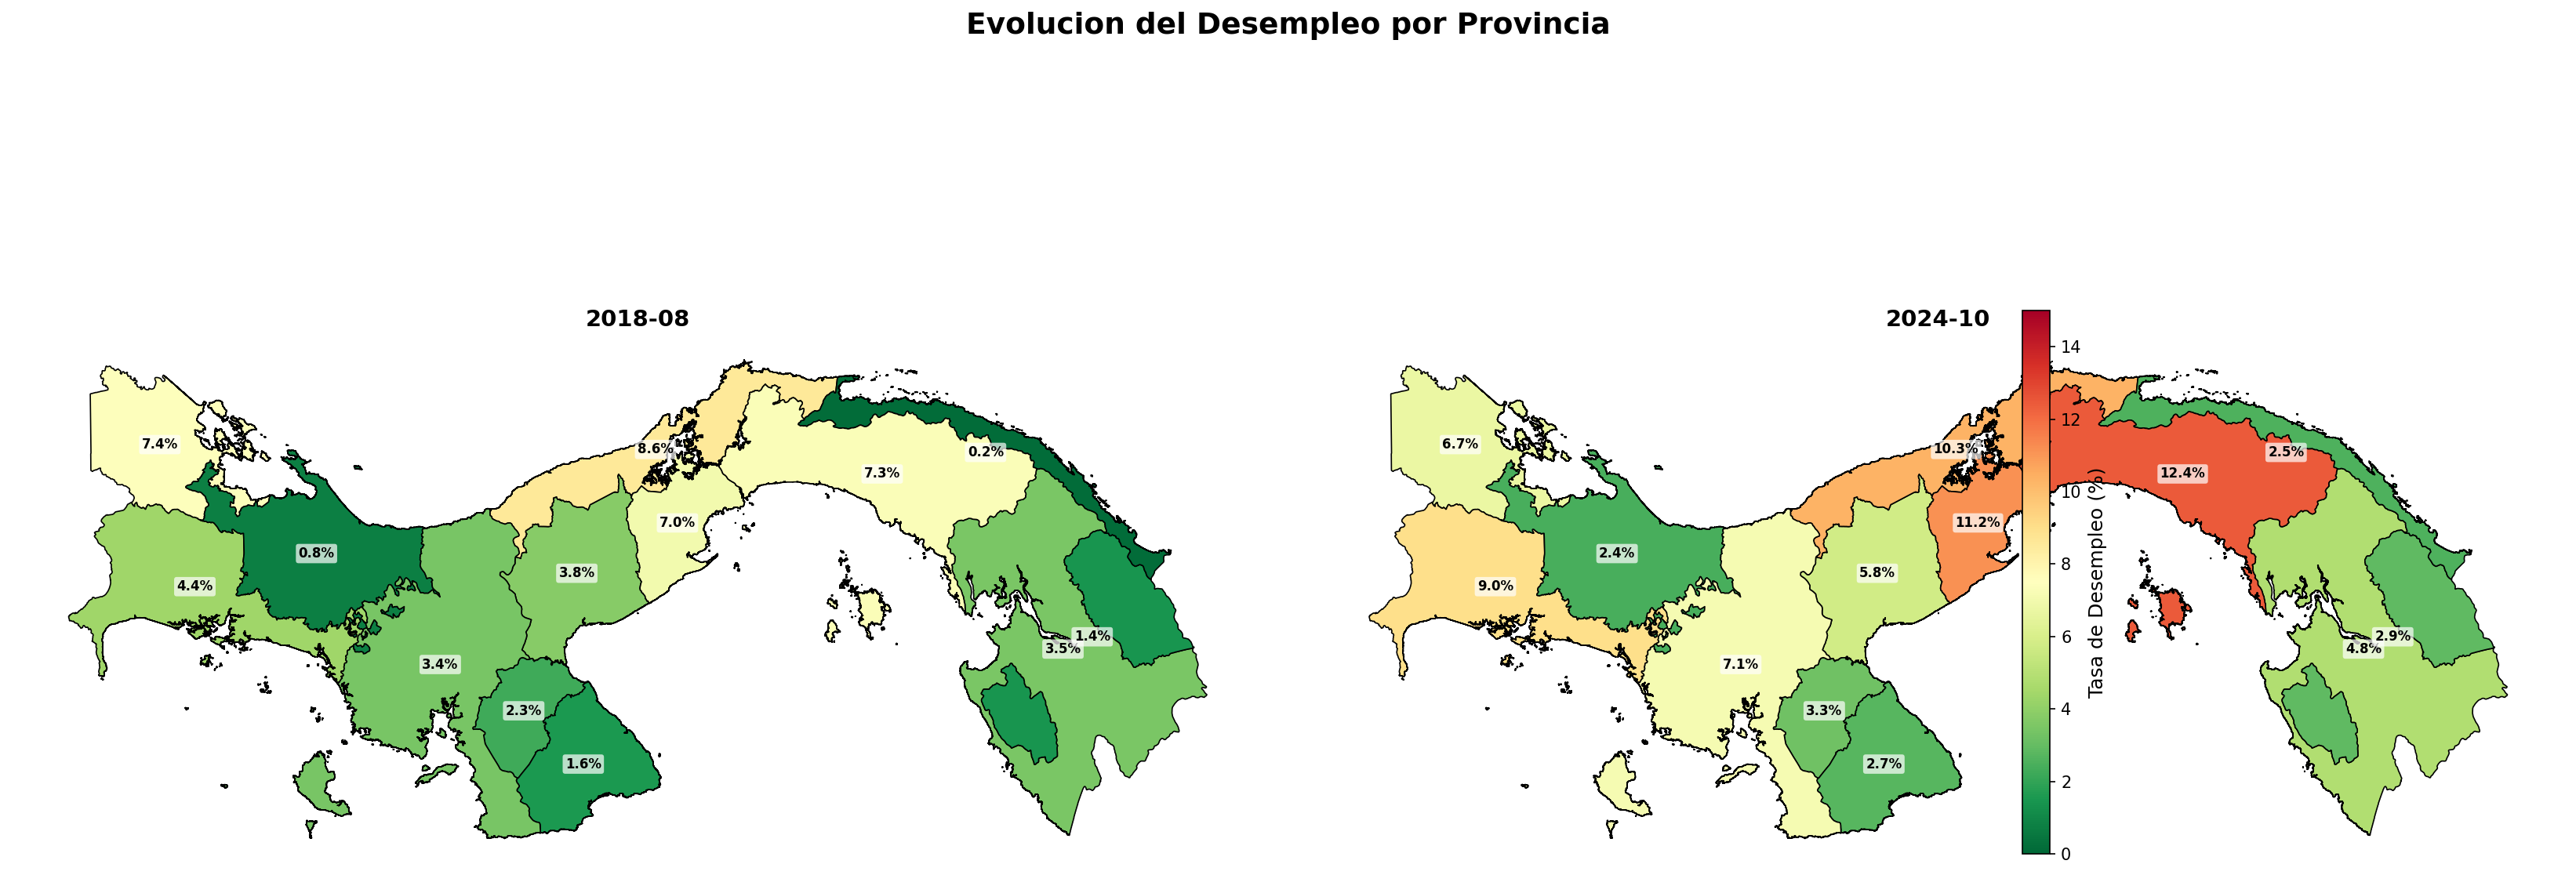

In [14]:
# Mapa comparativo
display(Image(filename=str(FIGURES_DIR / 'mapa_comparativo_2018_08_vs_2024_10.png'), width=580))

La comparacion entre 2018 y 2024 permite identificar que provincias mejoraron su situacion laboral y cuales empeoraron tras el periodo de crisis COVID. Este tipo de visualizacion facilita la evaluacion del impacto de las politicas publicas implementadas.

### 7.3 Prediccion del modelo vs realidad

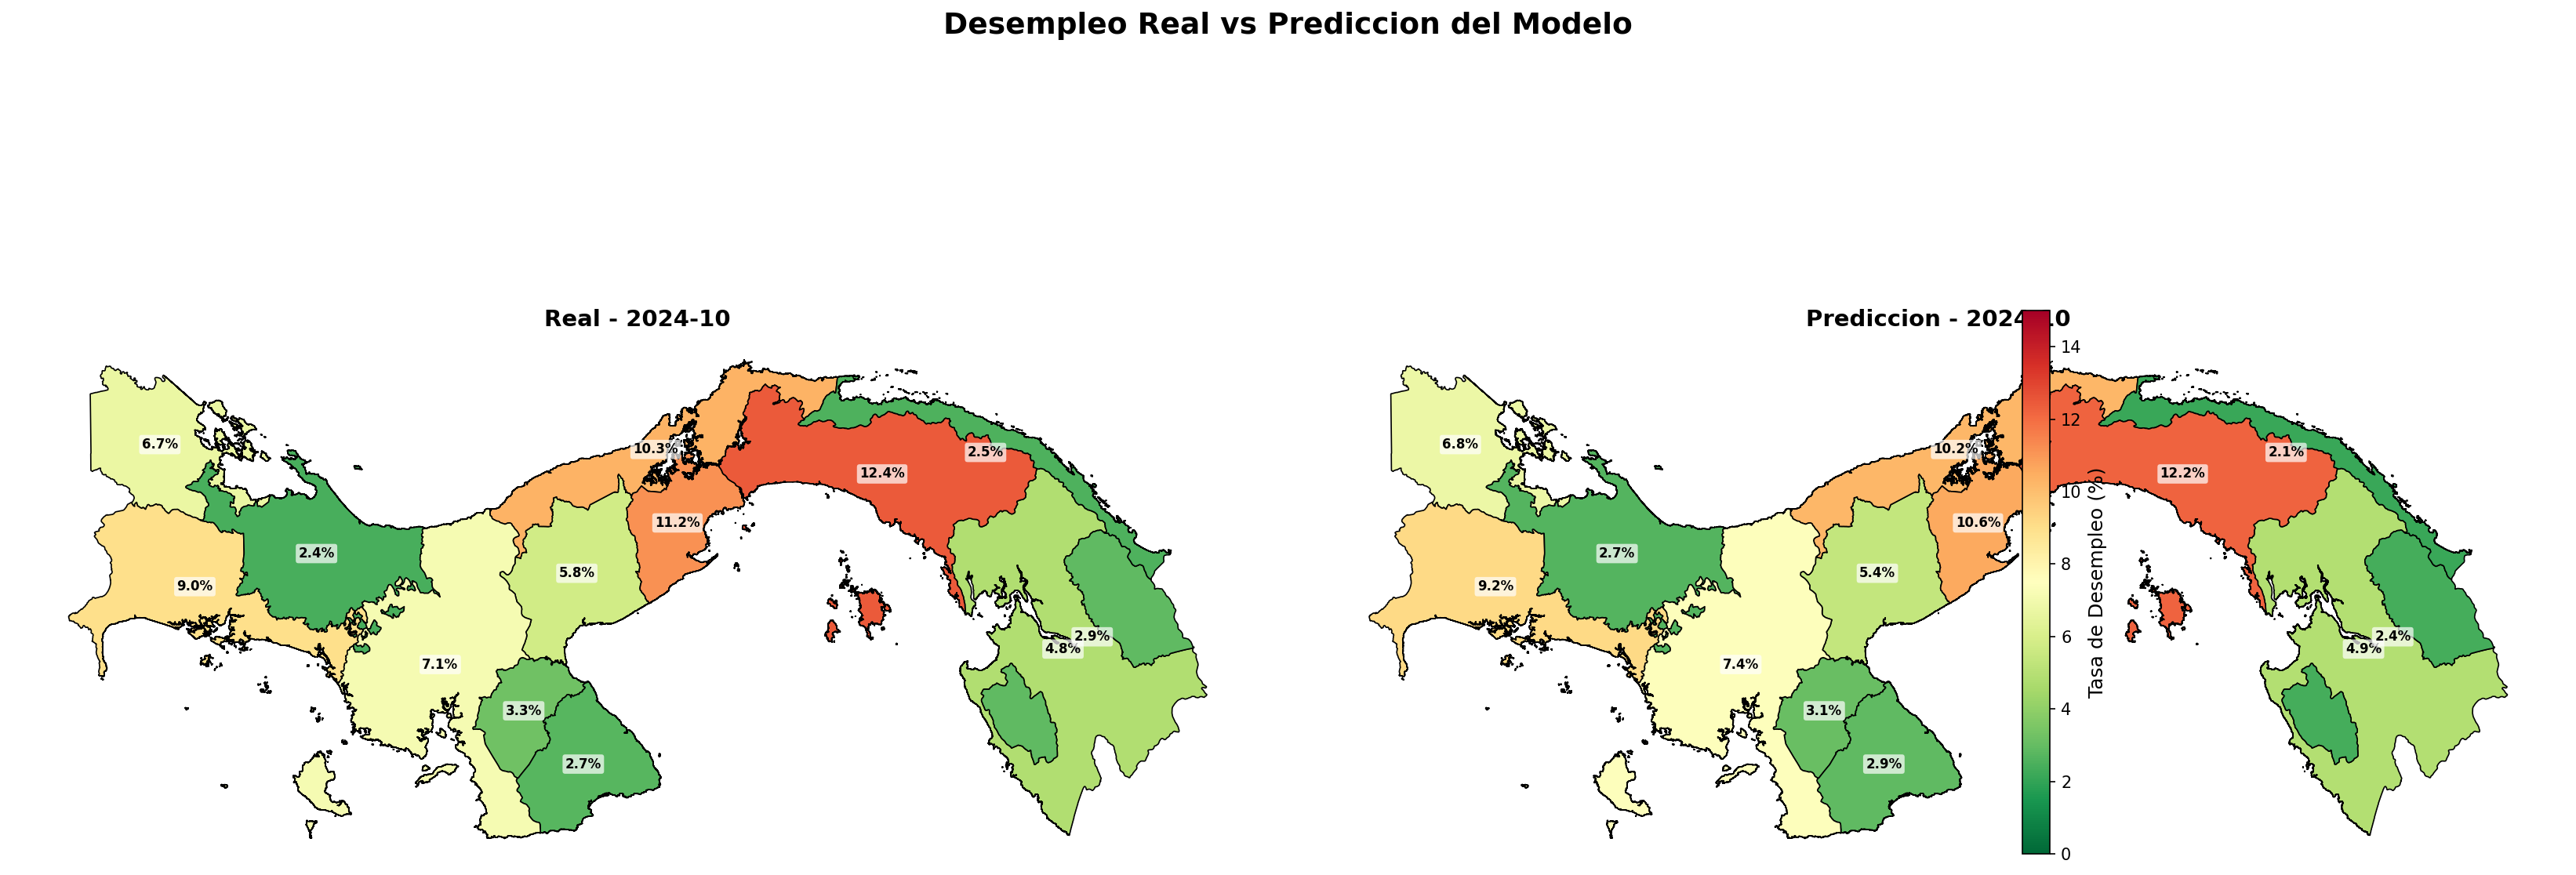

In [15]:
# Mapa real vs prediccion
display(Image(filename=str(FIGURES_DIR / 'mapa_real_vs_prediccion_2024_10.png'), width=580))

El mapa de comparacion real vs prediccion muestra visualmente que el modelo captura correctamente el patron geografico del desempleo. Las discrepancias son menores y se concentran en comarcas con datos mas limitados.

Ademas, se genero un **mapa interactivo con Folium** (disponible en `outputs/figures/mapa_interactivo_2024_10.html`) que permite hacer hover sobre cada provincia para ver los datos detallados de desempleo, prediccion y riesgo.

*Codigo de generacion de mapas en el Anexo (`src/visualization/mapas.py`).*

---
## 8. Productivizacion

Uno de los objetivos del proyecto es que el modelo no se quede como un ejercicio academico, sino que pueda ser utilizado como herramienta de toma de decisiones. Para ello se desarrollo un **dashboard interactivo con Streamlit** que permite a un usuario no tecnico explorar los datos y generar predicciones.

### 8.1 Arquitectura de la aplicacion

```
Usuario (navegador web)
       |
   Streamlit (app/app.py)
       |
   +---+---+---+
   |       |       |
 CSVs   modelo   mapas
 (reports/)  (.pkl)  (folium)
```

La aplicacion carga los artefactos pre-computados (predicciones, metricas, feature importance) y el modelo serializado (`modelo_desempleo.pkl`). No re-entrena el modelo en cada ejecucion, lo que garantiza tiempos de respuesta rapidos.

### 8.2 Secciones del dashboard

El dashboard tiene **8 secciones** accesibles desde el panel lateral:

| Seccion | Funcionalidad | Audiencia |
|---------|--------------|----------|
| **Resumen del Modelo** | KPIs principales, tabla de modelos, top features | Directivos, planificadores |
| **Mapa Interactivo** | Mapa de riesgo por provincia (Folium embebido) | Todos |
| **Evolucion Temporal** | Tendencias, animacion, heatmap | Analistas |
| **Predicciones vs Real** | Barras comparativas, scatter, residuos | Tecnicos, estadisticos |
| **Analisis de Riesgo** | Clasificacion por provincia, tabla detallada | Politica publica |
| **Rendimiento del Modelo** | Metricas CV, correlaciones, features | Cientificos de datos |
| **Interpretabilidad SHAP** | Explicacion de predicciones individuales con SHAP | Tecnicos, politica publica |
| **Predictor Interactivo** | Sliders para ajustar variables y predecir | Todos |

### 8.3 Interpretabilidad con SHAP

La seccion de **Interpretabilidad SHAP** utiliza SHapley Additive exPlanations (basada en teoria de juegos cooperativos) para explicar por que el modelo hace cada prediccion. Para cada provincia y periodo, SHAP descompone la prediccion en la contribucion de cada variable, indicando cuanto sube o baja la tasa de desempleo predicha cada factor. Esto permite identificar, por ejemplo, que el alto subempleo en Colon aumenta su prediccion en +2.3 pp, mientras que su nivel educativo la reduce en -0.8 pp.

### 8.4 Predictor interactivo

La seccion de **Predictor Interactivo** permite al usuario:

1. Seleccionar una provincia, area y sexo.
2. Ajustar 8 variables clave mediante sliders (desempleo previo, participacion, subempleo, informalidad, educacion, tamano empresa, salario, PIB).
3. El modelo genera una prediccion en tiempo real y clasifica el nivel de riesgo.
4. Se muestra la diferencia respecto al valor real del ultimo periodo.

Este componente permite hacer analisis de tipo **"que pasaria si..."** (what-if analysis). Por ejemplo: *"Si la tasa de subempleo en Colon sube del 20% al 30%, que efecto tiene en la prediccion de desempleo?"*

### 8.5 Ejecucion

```bash
streamlit run app/app.py
```

La aplicacion se abre en `http://localhost:8501` y es accesible desde cualquier navegador web.

*Codigo completo en el Anexo (`app/app.py` y `src/visualization/graficos_interactivos.py`).*

---
## 9. Resultados y Discusion

### 9.1 Predicciones del modelo

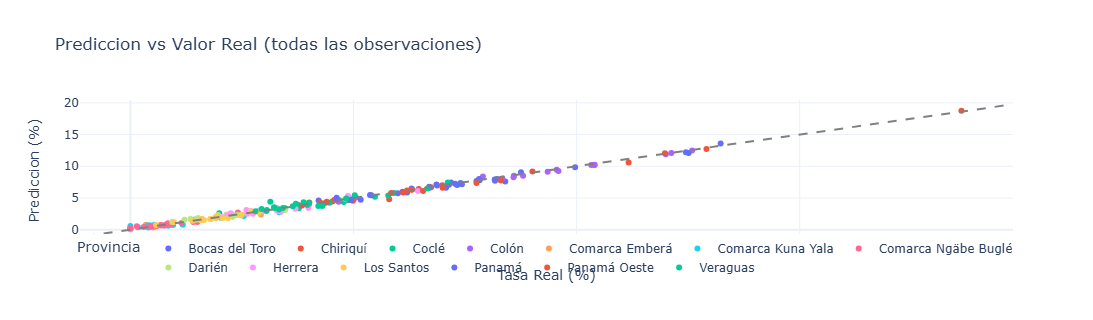

In [16]:
# Scatter prediccion vs real
fig = fig_scatter_prediccion_vs_real(df_pred)
fig.update_layout(height=320, title='Prediccion vs Valor Real (todas las observaciones)')
fig.show()

El scatter muestra que los puntos se agrupan alrededor de la linea diagonal (prediccion perfecta), confirmando que el modelo captura la estructura general del desempleo regional. Las mayores desviaciones ocurren en los extremos (tasas muy altas o muy bajas), donde los datos son mas escasos.

### 9.2 Predicciones por provincia (ultimo periodo)

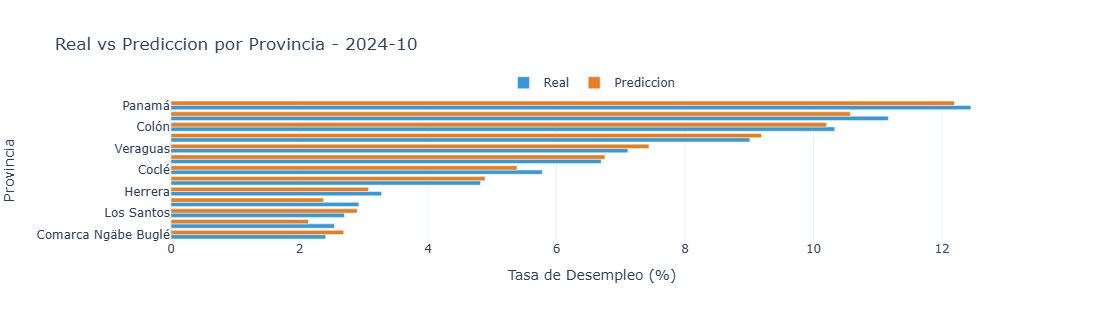

In [17]:
# Barras real vs prediccion para el ultimo periodo
ultimo_periodo = df_pred['periodo'].max()
fig = fig_real_vs_prediccion_barras(df_pred, ultimo_periodo)
fig.update_layout(height=320, title=f'Real vs Prediccion por Provincia - {ultimo_periodo}')
fig.show()

### 9.3 Interpretacion de los resultados

Los resultados del modelo permiten extraer conclusiones relevantes para la politica publica:

**1. El subempleo es el mejor predictor del desempleo futuro.** La variable mas importante del modelo (`pct_subempleo_lag1`) indica que las provincias con alto subempleo tienden a ver incrementos en el desempleo abierto en el periodo siguiente. Esto sugiere que las politicas deben enfocarse no solo en crear empleo, sino en mejorar la calidad del empleo existente.

**2. La inercia del desempleo es fuerte.** La segunda variable mas importante es la tasa de desempleo del periodo anterior. Esto implica que una vez que una provincia cae en desempleo alto, es dificil que se recupere rapidamente. Las intervenciones deben ser tempranas.

**3. La estructura empresarial importa.** El porcentaje de empresas grandes (`pct_empresa_grande`) y la educacion (`educacion_alta`, `pct_universitaria`) son predictores significativos. Las provincias con tejido empresarial de mayor tamano y poblacion mas educada tienden a tener menor desempleo.

**4. La brecha de genero persiste.** La variable `sexo_mujeres` y su interaccion `lag_x_sexo_mujeres` aparecen en el top 10, confirmando que el desempleo femenino tiene dinamicas diferenciadas que el modelo captura.

**5. El efecto COVID tiene cola larga.** La interaccion `lag_x_post_covid` sigue siendo relevante en 2024, lo que indica que el mercado laboral panameno no ha completado su recuperacion en todas las regiones.

### 9.4 Bondades y debilidades del modelo

| Aspecto | Bondad | Debilidad |
|---------|--------|----------|
| **Precision** | R-cuadrado 0.77, MAE 1.13 pp | Errores mayores en comarcas con pocos datos |
| **Validacion** | LOPO respeta la temporalidad | Solo 17 periodos limita la robustez |
| **Interpretabilidad** | Feature importance clara | No captura causalidad, solo correlacion |
| **Clasificacion de riesgo** | 79.4% precision (vs 33% azar) | Confusiones entre moderado y critico |
| **Productivizacion** | Dashboard funcional con predictor | No desplegado en la nube |
| **Alcance** | 13 provincias, 3 areas, 3 sexos | No llega a nivel de distrito o corregimiento |

---
## 10. Recomendaciones de Politica Publica

A partir de los hallazgos del modelo y el analisis geoespacial, se proponen las siguientes recomendaciones orientadas a la toma de decisiones:

### 10.1 Priorizar la reduccion del subempleo

El subempleo (`pct_subempleo_lag1`) es la variable mas determinante del desempleo futuro. Las provincias con alto subempleo visible transicionan a desempleo abierto en periodos de contraccion. Se recomienda:

- Implementar programas de **formalizacion del empleo** en provincias con subempleo superior al 20% (Colon, Bocas del Toro, comarcas indigenas).
- Incentivar la **conversion de empleos parciales a jornada completa** mediante beneficios fiscales a PYMES.

### 10.2 Intervencion temprana en provincias de riesgo critico

La fuerte inercia del desempleo (segundo predictor mas importante) implica que una vez que una provincia supera el umbral critico del 10%, la recuperacion es lenta. Se recomienda:

- Establecer un **sistema de alerta temprana** basado en el modelo predictivo, que active protocolos de intervencion cuando la tasa predicha supere el 8% (umbral de riesgo moderado).
- Focalizar recursos en **Colon, Bocas del Toro y las comarcas indigenas**, que presentan riesgo critico de forma recurrente.

### 10.3 Cerrar la brecha de genero en el empleo

El modelo identifica que el desempleo femenino tiene dinamicas diferenciadas (+2.0 pp respecto a hombres en promedio). Se recomienda:

- Disenar programas de empleo con **enfoque de genero**, especialmente en sectores donde la brecha es mayor.
- Ampliar la cobertura de **servicios de cuidado infantil** para facilitar la incorporacion de mujeres al mercado laboral.

### 10.4 Fortalecer el tejido empresarial y la educacion

Las provincias con mayor proporcion de empresas grandes y poblacion con educacion superior presentan menor desempleo. Se recomienda:

- Promover **incentivos para la instalacion de medianas y grandes empresas** fuera de la Ciudad de Panama, especialmente en las provincias centrales y occidentales.
- Invertir en **educacion tecnica y universitaria** alineada con la demanda del mercado laboral regional.

### 10.5 Utilizar el modelo como herramienta de planificacion

El dashboard desarrollado permite realizar analisis what-if y monitorear el riesgo por provincia. Se recomienda:

- Integrar el modelo en los procesos de **planificacion presupuestaria** del Ministerio de Trabajo, actualizando las predicciones con cada nueva Encuesta de Mercado Laboral del INEC.
- Utilizar los mapas de riesgo para la **asignacion geografica de recursos** de programas de empleo y capacitacion.

---
## 11. Conclusiones y Trabajo Futuro

### 11.1 Conclusiones

Este proyecto demuestra que es posible **predecir la tasa de desempleo regional en Panama con precision razonable** utilizando datos publicos del INEC y Banco Mundial. Los principales logros son:

1. **Se construyo un pipeline completo** de datos: desde la descarga automatizada de 560 archivos Excel (de los cuales se procesaron 59 cuadros clave) hasta la generacion de predicciones y mapas interactivos, pasando por feature engineering, modelado con 5 algoritmos y validacion cruzada temporal.

2. **El modelo XGBoost alcanza un R-cuadrado de 0.77** con validacion LOPO, lo que significa que explica mas de tres cuartas partes de la variabilidad del desempleo entre provincias y periodos. El error medio (MAE = 1.13 pp) es aceptable para toma de decisiones a nivel de planificacion.

3. **El subempleo y la inercia del desempleo son los factores mas determinantes.** Esto tiene implicaciones directas: las politicas de empleo deberian priorizar la calidad del empleo (reducir subempleo) y actuar tempranamente antes de que el desempleo se consolide.

4. **El analisis geoespacial confirma la concentracion geografica del riesgo.** Las comarcas indigenas y Colon presentan desempleo estructuralmente alto, mientras que las provincias centrales (Herrera, Los Santos) mantienen mercados laborales mas estables.

5. **El modelo esta productivizado** en un dashboard Streamlit con 8 secciones, incluyendo interpretabilidad SHAP y un predictor interactivo que permite analisis what-if. Esto facilita su uso por equipos de politica publica sin conocimientos tecnicos.

### 11.2 Lecciones aprendidas

- **La calidad de los datos es el principal reto.** Los archivos Excel del INEC tienen formatos inconsistentes entre periodos, lo que requirio un esfuerzo significativo de parseo y estandarizacion.
- **La validacion temporal es esencial.** Un k-fold aleatorio hubiera dado metricas infladas al mezclar periodos. El LOPO proporciona una evaluacion mas honesta del rendimiento real.
- **La productivizacion aporta valor tangible.** Un modelo en un notebook tiene valor academico; un dashboard con predictor tiene valor empresarial.

### 11.3 Trabajo futuro

1. **Granularidad geografica:** incorporar datos del Censo 2023 para extender las predicciones a nivel de distrito o corregimiento.
2. **Datos en tiempo real:** integrar fuentes adicionales (ej. busquedas de empleo en portales web) como proxy de alta frecuencia del mercado laboral.
3. **Modelos temporales:** explorar architecturas de redes neuronales recurrentes (LSTM) o Prophet para capturar estacionalidad.
4. **Despliegue en la nube:** publicar el dashboard en Streamlit Cloud para acceso publico.
5. **Autocorrelacion espacial:** aplicar Moran's I y modelos de regresion espacial (GWR) para capturar efectos de vecindad entre provincias.

---
## 12. Bibliografia

- INEC Panama (2024). *Encuesta de Mercado Laboral, Octubre 2024.* Instituto Nacional de Estadistica y Censo, Contraloria General de la Republica de Panama. https://www.inec.gob.pa

- Banco Mundial (2024). *World Development Indicators - Panama.* The World Bank Group. https://data.worldbank.org/country/panama

- Blanchard, O. & Katz, L. (1992). Regional Evolutions. *Brookings Papers on Economic Activity*, 1, 1-75.

- Chen, T. & Guestrin, C. (2016). XGBoost: A Scalable Tree Boosting System. *Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining*, 785-794.

- Humanitarian Data Exchange (2024). *Panama - Subnational Administrative Boundaries.* United Nations OCHA. https://data.humdata.org

- OIT (2023). *Panorama Laboral de America Latina y el Caribe.* Organizacion Internacional del Trabajo.

- Pedregosa, F. et al. (2011). Scikit-learn: Machine Learning in Python. *Journal of Machine Learning Research*, 12, 2825-2830.

- McKinney, W. (2010). Data Structures for Statistical Computing in Python. *Proceedings of the 9th Python in Science Conference*, 51-56.

- Plotly Technologies Inc. (2024). *Plotly Python Open Source Graphing Library.* https://plotly.com/python/

- Streamlit Inc. (2024). *Streamlit: The fastest way to build and share data apps.* https://streamlit.io

---

### Anexos

El codigo fuente completo del proyecto se encuentra en el repositorio adjunto, organizado de la siguiente manera:

| Componente | Ubicacion |
|------------|-----------|
| Configuracion global | `src/config.py` |
| Descarga y procesamiento de datos | `src/data/` (6 scripts) |
| Feature engineering | `src/features/crear_features.py` |
| Entrenamiento del modelo | `src/models/entrenar_modelo.py` |
| Visualizaciones interactivas (Plotly) | `src/visualization/graficos_interactivos.py` |
| Mapas geoespaciales (Folium/Geopandas) | `src/visualization/mapas.py` |
| Dashboard Streamlit | `app/app.py` |
| Analisis exploratorio detallado | `notebooks/01_analisis_exploratorio.ipynb` |
| Pipeline completo | `main.py` |
| Tests automatizados (80 tests) | `tests/` |

**Reproduccion:** Instalar dependencias con `pip install -r requirements.txt`, ejecutar `python main.py` para el pipeline completo, y `streamlit run app/app.py` para el dashboard.